In [1]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import tqdm
import copy
import gc
import sys
import os
import f90nml
import itertools

import bokeh
from bokeh.layouts import gridplot
from bokeh.models import ColumnDataSource, CDSView, GroupFilter, HoverTool
from bokeh.plotting import figure, show
from bokeh.transform import factor_cmap
from bokeh.palettes import Spectral11

from bokeh.models.mappers import CategoricalColorMapper

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

import scipy as sp
from scipy.sparse import linalg

import importlib

import analysis_functions

In [2]:
##### read in datafile after removing false transition and checking convergence  ######
dataDir='.'
simDataDir='/'.join([dataDir,''])
simDataFilename='../cx26-milestoning/Simulation_Milestone_Coordinate_Data.cAMP_newTransit_final.version.csv'
simDataFilePath='/'.join([simDataDir,simDataFilename])

simData=pd.read_csv(simDataFilePath)
display(simData.head())
simData.query('Window==52').Rep.unique()

,Window,Rep,Time,Rst06_X,Rst06_Y,Rst07_Z,Rst08_Z,X_Index,R
0,0,1,0.0,4.291,17.350,107.903,10.456,0,17.872750
1,0,1,500.0,4.117,17.984,108.105,10.275,0,18.449226
2,0,1,1000.0,4.162,17.821,108.509,9.857,0,18.300554
3,0,1,1500.0,4.621,17.773,107.792,10.539,0,18.363909
4,0,1,2000.0,4.761,17.909,108.495,9.874,0,18.531039


array([1, 2, 3, 4, 5])

In [3]:
##### reverse Window and X_Index for backward MFPT ########
lastWin=52
revData=pd.read_csv(simDataFilePath)
revData.Window=lastWin-revData.Window
revData.X_Index=lastWin-revData.X_Index
display(revData.head())
revData.query('Window==0').Rep.unique()

,Window,Rep,Time,Rst06_X,Rst06_Y,Rst07_Z,Rst08_Z,X_Index,R
0,52,1,0.0,4.291,17.350,107.903,10.456,52,17.872750
1,52,1,500.0,4.117,17.984,108.105,10.275,52,18.449226
2,52,1,1000.0,4.162,17.821,108.509,9.857,52,18.300554
3,52,1,1500.0,4.621,17.773,107.792,10.539,52,18.363909
4,52,1,2000.0,4.761,17.909,108.495,9.874,52,18.531039


array([1, 2, 3, 4, 5])

# **Milestoning equations**

Given milstone state $S_{ij}$ is the boundary between two adjacent Voronoi cells $B_i$ and $B_j$, and milestone state $S_{ik}$ are the boundary between two adjacent Voronoi cells $B_i$ and $B_k$. 

$k_{i→j}$ is the rate of attempted escape from cells $B_i$ to $B_j$.
At statistical equilibrium, the total flux in and out of each cell is zero, thus the equilibrium probability $\pi_i$ for the system to locate in cell $B_i$ satisfies a balance equation: 
$$\sum_{j=1,j\neq i} \pi_{j}k_{j→i}=\sum_{j=1, j\neq i} \pi_{i}k_{i→j} , \space \sum_{i=1} \pi_i =1 $$

The solution gives the equilibrium probability $\pi_i$ and consequently the free energy $-k_B Tln(\pi_i)$.

For each individual cell, 
let $q_{ij,ik}$ be the rate of moving from milestone state $S_{ij}$ to $S_{ik}$;

$n_{ij,ik}^i$ is the number of attemped transitions from $S_{ij}$ to $S_{ik}$, normalized by the time spend in cell $B_i$;

$r_{ij}^i$ is the time after having hit $S_{ij}$ before hitting any other milestone state, normalized by the total time spend in cell $B_i$: 

$$q_{ij,ik}= \frac{\pi_i n_{ij,ik}^i}{\pi_i r_{ij}^i +\pi_j r_{ij}^j }$$

The MFPT between milestone state $S_{ij}$ to $S_{ik}$ can be calculated from $q_{ij,ik}$.


In [4]:
########## use analysis_function.py to calculate Escape_vector and Reentry_vector #########
### for example, for window==50, Escape_Vector.unique() is [50 49 -1 51], Reentry_Vector.unique() is [-1 49 51]

simData['Frame']=simData['Time']
analysisFrame=analysis_functions.add_indexed_milestoning_analysis_columns(
    simData,
    windowColumn='Window',xIndexColumn='X_Index',frameCol='Frame',
    repColumn='Rep',groupingColumn=None,verbose=True,verboseLevel=1)
analysisFrame.tail()

/Users/luoy/Dropbox/python-notebook/Connexin-cAMP-milestoning/analysis_functions.py:424: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  simData[groupingCol]=0
/Users/luoy/Dropbox/python-notebook/Connexin-cAMP-milestoning/analysis_functions.py:434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  simData[repCol]=milestoneData[repCol]
/Users/luoy/Dropbox/python-notebook/Connexin-cAMP-milestoning/analysis_functions.py:437: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


--- --- --- Grouping Name: 0 --- --- ---
	binSet: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52] ; deltaVal: 1
	--- --- Window Name: 0 --- ---
		--- Replica Name: 1 2 3 4 

/Users/luoy/Dropbox/python-notebook/Connexin-cAMP-milestoning/analysis_functions.py:490: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  repData['Escape_Vector']=binVec-deltaVal
/Users/luoy/Dropbox/python-notebook/Connexin-cAMP-milestoning/analysis_functions.py:497: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  repData['Reentry_Vector']=reentryVec-deltaVal


5 6 ---
	--- --- ------ --- ---
	--- --- Window Name: 1 --- ---
		--- Replica Name: 1 2 3 4 5 6 7 8 ---
	--- --- ------ --- ---
	--- --- Window Name: 2 --- ---
		--- Replica Name: 1 3 4 5 6 7 8 9 10 11 12 13 ---
	--- --- ------ --- ---
	--- --- Window Name: 3 --- ---
		--- Replica Name: 1 2 3 4 5 ---
	--- --- ------ --- ---
	--- --- Window Name: 4 --- ---
		--- Replica Name: 2 4 5 6 7 8 9 ---
	--- --- ------ --- ---
	--- --- Window Name: 5 --- ---
		--- Replica Name: 1 3 4 5 6 7 ---
	--- --- ------ --- ---
	--- --- Window Name: 6 --- ---
		--- Replica Name: 1 3 4 5 6 7 8 9 10 ---
	--- --- ------ --- ---
	--- --- Window Name: 7 --- ---
		--- Replica Name: 2 4 5 6 7 8 9 10 ---
	--- --- ------ --- ---
	--- --- Window Name: 8 --- ---
		--- Replica Name: 1 3 4 5 6 7 8 9 10 11 ---
	--- --- ------ --- ---
	--- --- Window Name: 9 --- ---
		--- Replica Name: 6 7 8 9 10 11 12 13 ---
	--- --- ------ --- ---
	--- --- Window Name: 10 --- ---
		--- Replica Name: 1 2 3 4 5 6 7 8 9 10 11 ---
	--- --- 

,Window,X_Index,Group,Rep,Frame,Escape_Vector,Reentry_Vector
14457913,52,52,0,5,2285000.0,52,51
14457914,52,52,0,5,2285500.0,52,51
14457915,52,52,0,5,2286000.0,52,51
14457916,52,52,0,5,2286500.0,52,51
14457917,52,52,0,5,2288000.0,52,51


In [5]:
###### calucalate Escape_vector and Reentry_vector for backward transition #########
revData['Frame']=revData['Time']
rev_analysisFrame=analysis_functions.add_indexed_milestoning_analysis_columns(
    revData,
    windowColumn='Window',xIndexColumn='X_Index',frameCol='Frame',
    repColumn='Rep',groupingColumn=None,verbose=True,verboseLevel=1)
rev_analysisFrame.tail()

/Users/luoy/Dropbox/python-notebook/Connexin-cAMP-milestoning/analysis_functions.py:424: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  simData[groupingCol]=0
/Users/luoy/Dropbox/python-notebook/Connexin-cAMP-milestoning/analysis_functions.py:434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  simData[repCol]=milestoneData[repCol]
/Users/luoy/Dropbox/python-notebook/Connexin-cAMP-milestoning/analysis_functions.py:437: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


--- --- --- Grouping Name: 0 --- --- ---
	binSet: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52] ; deltaVal: 1
	--- --- Window Name: 0 --- ---
		--- Replica Name: 1 2 3 4 5 

/Users/luoy/Dropbox/python-notebook/Connexin-cAMP-milestoning/analysis_functions.py:490: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  repData['Escape_Vector']=binVec-deltaVal
/Users/luoy/Dropbox/python-notebook/Connexin-cAMP-milestoning/analysis_functions.py:497: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  repData['Reentry_Vector']=reentryVec-deltaVal


---
	--- --- ------ --- ---
	--- --- Window Name: 1 --- ---
		--- Replica Name: 1 2 ---
	--- --- ------ --- ---
	--- --- Window Name: 2 --- ---
		--- Replica Name: 1 3 4 ---
	--- --- ------ --- ---
	--- --- Window Name: 3 --- ---
		--- Replica Name: 1 2 3 ---
	--- --- ------ --- ---
	--- --- Window Name: 4 --- ---
		--- Replica Name: 1 2 ---
	--- --- ------ --- ---
	--- --- Window Name: 5 --- ---
		--- Replica Name: 1 2 3 ---
	--- --- ------ --- ---
	--- --- Window Name: 6 --- ---
		--- Replica Name: 1 2 3 ---
	--- --- ------ --- ---
	--- --- Window Name: 7 --- ---
		--- Replica Name: 1 2 3 4 5 6 ---
	--- --- ------ --- ---
	--- --- Window Name: 8 --- ---
		--- Replica Name: 1 2 3 4 5 6 ---
	--- --- ------ --- ---
	--- --- Window Name: 9 --- ---
		--- Replica Name: 1 3 4 5 6 7 ---
	--- --- ------ --- ---
	--- --- Window Name: 10 --- ---
		--- Replica Name: 1 ---
	--- --- ------ --- ---
	--- --- Window Name: 11 --- ---
		--- Replica Name: 1 ---
	--- --- ------ --- ---
	--- --- Window Na

,Window,X_Index,Group,Rep,Frame,Escape_Vector,Reentry_Vector
115968,52,52,0,6,4997500.0,52,51
115969,52,52,0,6,4998000.0,52,51
115970,52,52,0,6,4998500.0,52,51
115971,52,52,0,6,4999000.0,52,51
115972,52,52,0,6,4999500.0,52,51


binSet [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52]


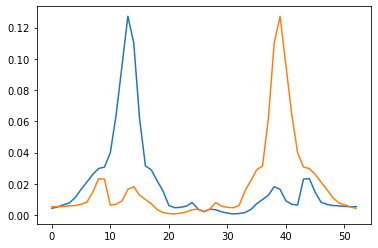

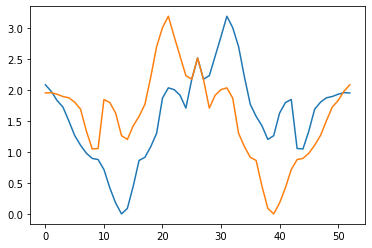

tempVec [2.07919191 1.9745407  1.82584736 1.71967014 1.49795069 1.26346392
 1.10663514 0.9767007  0.89401689 0.87556898 0.71439575 0.41991725
 0.17558256 0.         0.0883126  0.44617884 0.86135856 0.91211561
 1.08381872 1.29833852 1.86558932 2.030578   2.00164052 1.91151725
 1.7045909  2.16763799 2.51129597 2.17063179 2.22667097 2.54105447
 2.85683175 3.18398235 3.00033494 2.69496073 2.20685671 1.7660263
 1.5708038  1.41898959 1.19996926 1.26019236 1.62295692 1.79372811
 1.84316961 1.05355075 1.0460985  1.33357171 1.68742253 1.79992662
 1.87016845 1.89093697 1.92747407 1.95358494 1.94804682]
revVec [1.94804682 1.95358494 1.92747407 1.89093697 1.87016845 1.79992662
 1.68742253 1.33357171 1.0460985  1.05355075 1.84316961 1.79372811
 1.62295692 1.26019236 1.19996926 1.41898959 1.5708038  1.7660263
 2.20685671 2.69496073 3.00033494 3.18398235 2.85683175 2.54105447
 2.22667097 2.17063179 2.51129597 2.16763799 1.7045909  1.91151725
 2.00164052 2.030578   1.86558932 1.29833852 1.08381872 0.9

In [6]:
#################### pi_vector and PMF ################

kb=0.001985875 #kcal/mol
simTemp=310.15
kbT=kb*simTemp

binSet=np.sort(np.unique(np.concatenate([
    analysisFrame['Window'].unique(),
    analysisFrame['X_Index'].unique()
])))
print("binSet",binSet)

testEscapeData=analysis_functions.compute_analysis_group_pi_vector(
    groupDataFrame=analysisFrame,windowColumn='Window',binSet=binSet,
    giveEscapeMat=True,giveCounts=True,giveBins=True,giveBinMap=True,
    giveCountsMat=True)
#print('testEscapeData:',testEscapeData)

rev_testEscapeData=analysis_functions.compute_analysis_group_pi_vector(
    groupDataFrame=rev_analysisFrame,windowColumn='Window',binSet=binSet,
    giveEscapeMat=True,giveCounts=True,giveBins=True,giveBinMap=True,
    giveCountsMat=True)

# piVec is the eigenvec of escapMat, whose eigenval is 1. Sum of piVec is 1
# i.e. escapeEig=np.linalg.eig(escapeMat.todense().T), piVec=np.array(escapeEig[1])
plt.plot(testEscapeData['piVec'])
plt.plot(rev_testEscapeData['piVec'])
plt.show()

tempVec=-kbT*np.log(testEscapeData['piVec']) #-log(piVec) is PMF in kT
tempVec=tempVec-np.min(tempVec)
plt.plot(tempVec)
revVec=-kbT*np.log(rev_testEscapeData['piVec']) #-log(piVec) is PMF in kT
revVec=revVec-np.min(revVec)
plt.plot(revVec)
#plt.yticks(np.arange(0,5,0.5))
#plt.grid( linestyle='-', linewidth=1)
plt.show()

print("tempVec", tempVec)
print("revVec", revVec)


In [7]:
############### Compute transition rate matrix ##################
#importlib.reload(analysis_functions)
QdataDict=analysis_functions.compute_analysis_group_Qdata(
    groupDataFrame=analysisFrame,windowColumn='Window',binSet=binSet,
                                     giveBins=False,giveBinMap=False,
                                     giveEscapeMat=True,giveCounts=False,
                                     giveCountsMat=False,givePiVec=True)
for entryKey in QdataDict:
    print(entryKey,':',QdataDict[entryKey])


Computing R and N: ( 0 : 1 2 3 4 5 6 ) ( 1 : 1 2 3 4 5 6 7 8 ) ( 2 : 1 3 4 5 6 7 8 9 10 11 12 13 ) ( 3 : 1 2 3 4 5 ) ( 4 : 2 4 5 6 7 8 9 ) ( 5 : 1 3 4 5 6 7 ) ( 6 : 1 3 4 5 6 7 8 9 10 ) ( 7 : 2 4 5 6 7 8 9 10 ) ( 8 : 1 3 4 5 6 7 8 9 10 11 ) ( 9 : 6 7 8 9 10 11 12 13 ) ( 10 : 1 2 3 4 5 6 7 8 9 10 11 ) ( 11 : 1 2 3 4 5 6 7 ) ( 12 : 1 2 3 4 5 6 ) ( 13 : 1 3 4 5 ) ( 14 : 1 2 3 4 5 6 ) ( 15 : 1 2 3 ) ( 16 : 1 2 3 4 ) ( 17 : 1 2 3 4 ) ( 18 : 1 2 3 4 ) ( 19 : 1 2 3 4 ) ( 20 : 1 ) ( 21 : 1 2 ) ( 22 : 3 ) ( 23 : 1 ) ( 24 : 3 ) ( 25 : 1 ) ( 26 : 1 ) ( 27 : 1 2 ) ( 28 : 1 ) ( 29 : 3 ) ( 30 : 1 ) ( 31 : 1 ) ( 32 : 1 ) ( 33 : 1 ) ( 34 : 1 ) ( 35 : 4 5 ) ( 36 : 1 ) ( 37 : 1 2 3 4 ) ( 38 : 1 ) ( 39 : 1 ) ( 40 : 1 ) ( 41 : 1 ) ( 42 : 1 ) ( 43 : 1 3 4 5 6 7 ) ( 44 : 1 2 3 4 5 6 ) ( 45 : 1 2 3 4 5 6 ) ( 46 : 1 2 3 ) ( 47 : 1 2 3 ) ( 48 : 1 2 ) ( 49 : 1 2 3 ) ( 50 : 1 3 4 ) ( 51 : 1 2 ) ( 52 : 1 2 3 4 5 ) 
Rmat :   (0, 1)	790.4624912661585
  (1, 0)	437.07076823933494
  (1, 2)	525.9872507157548
  (2, 1)	5

In [8]:
################ Compute transition rate matrix for backward transition ############
rev_QdataDict=analysis_functions.compute_analysis_group_Qdata(
    groupDataFrame=rev_analysisFrame,windowColumn='Window',binSet=binSet,
                                     giveBins=False,giveBinMap=False,
                                     giveEscapeMat=True,giveCounts=False,
                                     giveCountsMat=False,givePiVec=True)
for entryKey in rev_QdataDict:
    print(entryKey,':',rev_QdataDict[entryKey])


Computing R and N: ( 0 : 1 2 3 4 5 ) ( 1 : 1 2 ) ( 2 : 1 3 4 ) ( 3 : 1 2 3 ) ( 4 : 1 2 ) ( 5 : 1 2 3 ) ( 6 : 1 2 3 ) ( 7 : 1 2 3 4 5 6 ) ( 8 : 1 2 3 4 5 6 ) ( 9 : 1 3 4 5 6 7 ) ( 10 : 1 ) ( 11 : 1 ) ( 12 : 1 ) ( 13 : 1 ) ( 14 : 1 ) ( 15 : 1 2 3 4 ) ( 16 : 1 ) ( 17 : 4 5 ) ( 18 : 1 ) ( 19 : 1 ) ( 20 : 1 ) ( 21 : 1 ) ( 22 : 1 ) ( 23 : 3 ) ( 24 : 1 ) ( 25 : 1 2 ) ( 26 : 1 ) ( 27 : 1 ) ( 28 : 3 ) ( 29 : 1 ) ( 30 : 3 ) ( 31 : 1 2 ) ( 32 : 1 ) ( 33 : 1 2 3 4 ) ( 34 : 1 2 3 4 ) ( 35 : 1 2 3 4 ) ( 36 : 1 2 3 4 ) ( 37 : 1 2 3 ) ( 38 : 1 2 3 4 5 6 ) ( 39 : 1 3 4 5 ) ( 40 : 1 2 3 4 5 6 ) ( 41 : 1 2 3 4 5 6 7 ) ( 42 : 1 2 3 4 5 6 7 8 9 10 11 ) ( 43 : 6 7 8 9 10 11 12 13 ) ( 44 : 1 3 4 5 6 7 8 9 10 11 ) ( 45 : 2 4 5 6 7 8 9 10 ) ( 46 : 1 3 4 5 6 7 8 9 10 ) ( 47 : 1 3 4 5 6 7 ) ( 48 : 2 4 5 6 7 8 9 ) ( 49 : 1 2 3 4 5 ) ( 50 : 1 3 4 5 6 7 8 9 10 11 12 13 ) ( 51 : 1 2 3 4 5 6 7 8 ) ( 52 : 1 2 3 4 5 6 ) 
Rmat :   (0, 1)	976.7764394982818
  (1, 0)	481.88920961729514
  (1, 2)	518.3844657047711
  (2, 1)	5

windowCenters [-43.4 -41.4 -39.4 -37.4 -35.4 -33.4 -31.4 -29.4 -27.4 -25.4 -23.4 -21.4
 -19.4 -17.4 -15.4 -13.4 -11.4  -9.4  -7.4  -5.4  -3.4  -1.4   0.6   2.6
   4.6   6.6   8.6  10.6  12.6  14.6  16.6  18.6  20.6  22.6  24.6  26.6
  28.6  30.6  32.6  34.6  36.6  38.6  40.6  42.6  44.6  46.6  48.6  50.6
  52.6  54.6  56.6  58.6  60.6] len 53
outward milestoneCenters [-42.4 -40.4 -38.4 -36.4 -34.4 -32.4 -30.4 -28.4 -26.4 -24.4 -22.4 -20.4
 -18.4 -16.4 -14.4 -12.4 -10.4  -8.4  -6.4  -4.4  -2.4  -0.4   1.6   3.6
   5.6   7.6   9.6  11.6  13.6  15.6  17.6  19.6  21.6  23.6  25.6  27.6
  29.6  31.6  33.6  35.6  37.6  39.6  41.6  43.6  45.6  47.6  49.6  51.6
  53.6  55.6  57.6] len 51
inward milestoneCenters [ 59.6  57.6  55.6  53.6  51.6  49.6  47.6  45.6  43.6  41.6  39.6  37.6
  35.6  33.6  31.6  29.6  27.6  25.6  23.6  21.6  19.6  17.6  15.6  13.6
  11.6   9.6   7.6   5.6   3.6   1.6  -0.4  -2.4  -4.4  -6.4  -8.4 -10.4
 -12.4 -14.4 -16.4 -18.4 -20.4 -22.4 -24.4 -26.4 -28.4 -30.4 -32.4 -

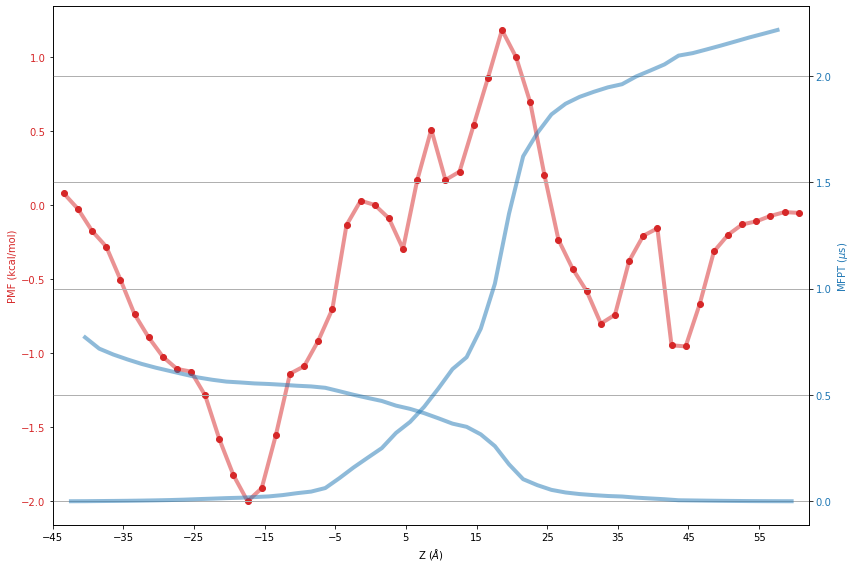

In [9]:
############### Plot PMF and MFPT with z-axis #################
windowCenters=np.arange(-43.4,62.6,2.0)
print("windowCenters", windowCenters, "len", len(windowCenters))
milestoneCenters=np.arange(-42.4,59.6,2.0)
print("outward milestoneCenters",milestoneCenters, "len", len(milestoneCenters))
rev_milestoneCenters=np.arange(59.6,-42.4,-2.0)
print("inward milestoneCenters",rev_milestoneCenters, "len", len(rev_milestoneCenters))
print("len", len(windowCenters),len(milestoneCenters))

###### PMF ###########
tempVec=-kbT*np.log(testEscapeData['piVec']) #-log(piVec) is PMF in kT
tempVec=tempVec-np.min(tempVec)-2
fig, ax1 = plt.subplots(figsize=(12,8))

color = 'tab:red'
ax1.set_xlabel('Z ($\AA$)')
ax1.set_ylabel("PMF (kcal/mol)", color=color)
ax1.plot(windowCenters,tempVec, color=color,linewidth=4, alpha=.5)
ax1.plot(windowCenters,tempVec,'ro', color=color)
ax1.tick_params(axis='y', labelcolor=color)

###### Inward and outward MFPT #############
def reverse(lst):
    return [ele for ele in reversed(lst)]

tauVec=QdataDict['tauVec']
rev_tauVec=rev_QdataDict['tauVec']
frq=1e-6 #frame rate in us

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel("MFPT ($\mu$s)", color=color)  # we already handled the x-label with ax1

ax2.plot(rev_milestoneCenters,(np.max(rev_tauVec)-rev_tauVec)*frq, color=color,linewidth=4, alpha=.5)
ax2.plot(milestoneCenters,(np.max(tauVec)-tauVec)*frq,linewidth=4, alpha=.5)

ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.xticks(np.arange(-45,62,10))
plt.yticks(np.arange(0,2.4,0.5))
plt.xlim(-45,62)
plt.grid( linestyle='-', linewidth=1)

plt.show()

